In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import scipy.stats
from scipy import optimize

In [3]:
import nilearn
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [5]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [6]:
dir_root = join('/mnt/sdb2/GL/fmri_data')
dir_stat = join(dir_root, 'stats')
dir_mask = join(dir_root, 'masks')

In [7]:
list_subj = [
    'GL03', 'GL04', 'GL05', 'GL06', 'GL07'
    , 'GL08', 'GL09', 'GL10', 'GL11', 'GL12'
    , 'GL14', 'GL15', 'GL16', 'GL17', 'GL18'
    , 'GL19', 'GL20', 'GL21', 'GL22', 'GL24'
    , 'GL25', 'GL26', 'GL27', 'GL29'
]

In [8]:
bg_img = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

In [9]:
img_putamen = join(dir_mask, 'mask.Putamen.GL.nii')

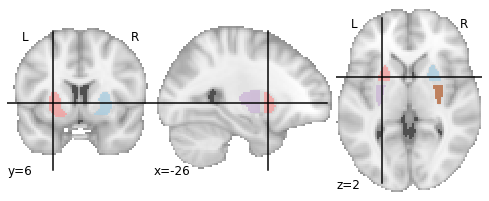

In [10]:
nilearn.plotting.plot_roi(img_putamen, cut_coords=(-26, 6, 2), cmap='Paired')
# nilearn.plotting.view_img(img_putamen, cmap='Accent', symmetric_cmap=False, black_bg=False)

In [11]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_putamen, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['raPutamen', 'laPutamen', 'lpPutamen', 'rpPutamen']
)

---

In [17]:
df = pd.DataFrame(columns=masker.labels)

for ii, subj in enumerate(list_subj):
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Tstat.nii'%(subj,subj))
#     nilearn.plotting.view_img(img_beta, bg_img=bg_img, black_bg=False)
    
    df.loc[ii,:] = masker.fit_transform(img_beta)

# df = df.set_axis(list_subj, axis='index')
df['subj'] = list_subj
df['source'] = 'reward'

df

,raPutamen,laPutamen,lpPutamen,rpPutamen,subj,source
0,2.029013,1.630403,1.569605,2.373142,GL03,reward
1,1.438145,0.875346,0.155321,-0.055271,GL04,reward
2,5.42716,4.863859,4.772534,4.764967,GL05,reward
3,2.449591,3.779471,2.243562,1.613369,GL06,reward
4,2.637859,1.979944,1.324521,1.672792,GL07,reward
5,3.077863,3.036242,1.224339,1.260359,GL08,reward
6,4.443083,4.34704,2.646572,3.000595,GL09,reward
7,3.151894,2.831991,0.669099,1.075489,GL10,reward
8,3.107622,2.998256,1.874275,2.392006,GL11,reward
9,0.148526,-0.122418,-0.717663,0.170179,GL12,reward


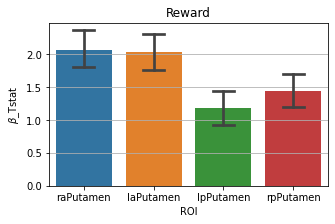

In [18]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(data=df, ci=68, capsize=.3, ax=ax)
ax.set(ylabel=r'$\beta$_Tstat', xlabel='ROI', title='Reward')
ax.grid(axis='y')

In [19]:
df = df.melt(id_vars=['subj', 'source'])
df.rename(columns={'variable':'ROI'}, inplace=True)
df

,subj,source,ROI,value
0,GL03,reward,raPutamen,2.029013
1,GL04,reward,raPutamen,1.438145
2,GL05,reward,raPutamen,5.42716
3,GL06,reward,raPutamen,2.449591
4,GL07,reward,raPutamen,2.637859
...,...,...,...,...
91,GL24,reward,rpPutamen,0.483232
92,GL25,reward,rpPutamen,2.585095
93,GL26,reward,rpPutamen,1.820041
94,GL27,reward,rpPutamen,1.141534


In [20]:
dg = pd.DataFrame(columns=masker.labels)

for ii, subj in enumerate(list_subj):
    img_beta = join(dir_stat, 'GLM.Move_Stop/statMove.%s.Move-Stop_GLT#0_Tstat.nii'%subj)
#     nilearn.plotting.view_img(img_beta, bg_img=bg_img, black_bg=False)
    
    dg.loc[ii,:] = masker.fit_transform(img_beta)

# dg = dg.set_axis(list_subj, axis='index')
dg['subj'] = list_subj
dg['source'] = 'move-stop'

dg

,raPutamen,laPutamen,lpPutamen,rpPutamen,subj,source
0,0.934127,1.452784,1.822491,1.14539,GL03,move-stop
1,-1.422915,-0.818083,0.022443,-1.244262,GL04,move-stop
2,-1.325858,-0.531485,0.870664,-1.104812,GL05,move-stop
3,-1.498666,-1.357965,0.217414,-0.432193,GL06,move-stop
4,-0.968694,-0.559568,0.447159,0.148233,GL07,move-stop
5,-0.110258,0.061934,0.561688,0.328656,GL08,move-stop
6,0.592187,0.268023,0.291017,-0.293784,GL09,move-stop
7,-0.90584,-0.690523,0.751165,-0.77065,GL10,move-stop
8,-0.696601,0.093144,0.458625,-1.673696,GL11,move-stop
9,1.42257,1.352799,2.69425,0.930629,GL12,move-stop


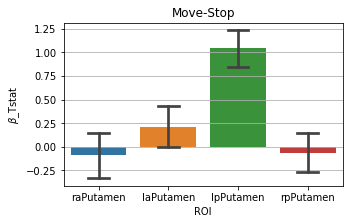

In [21]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(data=dg, ci=68, capsize=.3, ax=ax)
ax.set(ylabel=r'$\beta$_Tstat', xlabel='ROI', title='Move-Stop')
ax.grid(axis='y')

In [22]:
dg = dg.melt(id_vars=['subj', 'source'])
dg.rename(columns={'variable':'ROI'}, inplace=True)
dg

,subj,source,ROI,value
0,GL03,move-stop,raPutamen,0.934127
1,GL04,move-stop,raPutamen,-1.422915
2,GL05,move-stop,raPutamen,-1.325858
3,GL06,move-stop,raPutamen,-1.498666
4,GL07,move-stop,raPutamen,-0.968694
...,...,...,...,...
91,GL24,move-stop,rpPutamen,-0.602439
92,GL25,move-stop,rpPutamen,-1.522866
93,GL26,move-stop,rpPutamen,0.275824
94,GL27,move-stop,rpPutamen,-1.542311


In [23]:
dh = pd.merge(df, dg, how='outer', on=None)
dh

,subj,source,ROI,value
0,GL03,reward,raPutamen,2.029013
1,GL04,reward,raPutamen,1.438145
2,GL05,reward,raPutamen,5.42716
3,GL06,reward,raPutamen,2.449591
4,GL07,reward,raPutamen,2.637859
...,...,...,...,...
187,GL24,move-stop,rpPutamen,-0.602439
188,GL25,move-stop,rpPutamen,-1.522866
189,GL26,move-stop,rpPutamen,0.275824
190,GL27,move-stop,rpPutamen,-1.542311


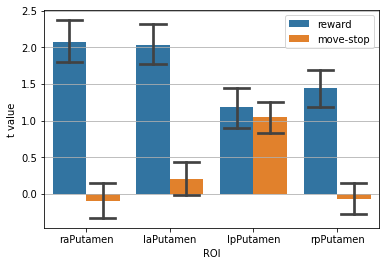

In [24]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.barplot(data=dh, x='ROI', y='value', hue='source', ci=68, capsize=.3, ax=ax)
ax.set(ylabel='t value')
ax.grid(axis='y')
ax.legend()

In [28]:
fig.savefig('/home/sungbeenpark/Github/labs/GL/scripts/GL.GLM.barplot.png', dpi=300, facecolor=[1,1,1,1])